<a href="https://colab.research.google.com/github/kaysriram/MLZoomCamp2025/blob/main/DataTalksHW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-10-21 15:12:51--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.01s   

2025-10-21 15:12:51 (7.99 MB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]



Data Preparation and EDA

In [3]:
df=pd.read_csv('course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [4]:
df.isnull().sum()

,0
lead_source,128
industry,134
number_of_courses_viewed,0
annual_income,181
employment_status,100
location,63
interaction_count,0
lead_score,0
converted,0


In [5]:
df[df.select_dtypes(include='object').columns] = df[df.select_dtypes(include='object').columns].fillna('NA')
df[df.select_dtypes(exclude='object').columns] = df[df.select_dtypes(exclude='object').columns].fillna(0.0)

In [6]:
df.isnull().sum()

,0
lead_source,0
industry,0
number_of_courses_viewed,0
annual_income,0
employment_status,0
location,0
interaction_count,0
lead_score,0
converted,0


In [7]:
from sklearn.model_selection import train_test_split
X=df.drop(columns=['converted'])
y=df['converted']
X_train,X_temp,y_train,y_temp=train_test_split(X,y,test_size=0.4,random_state=1)      #60 40 split
X_val,X_test,y_val,y_test=train_test_split(X_temp,y_temp,test_size=0.5,random_state=1) # 40 split into 20 20 each

In [8]:
from sklearn.metrics import roc_auc_score
variables=['lead_score',
'number_of_courses_viewed',
'interaction_count',
'annual_income']

scores={}
for var in variables:
  x=X_train[var]
  y=y_train

  if x.nunique()<=1:
    scores[var]=np.nan
    continue
  scores[var]=roc_auc_score(y,x)

  if scores[var]<0.5:
    scores[var]=1-scores[var]

max(scores,key=scores.get)

'number_of_courses_viewed'

Q2

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

cat_cols = X_train.select_dtypes(include='object').columns
num_cols = X_train.select_dtypes(exclude='object').columns

preprocessor = ColumnTransformer(
transformers=[
    ('num', 'passthrough', num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
]
)

# Baseline model (C=1.0)
base_clf = Pipeline(steps=[
('preprocessor', preprocessor),
('model', LogisticRegression(solver='liblinear', C=1.0, max_iter=1000))
])
base_clf.fit(X_train, y_train)
y_val_pred_base = base_clf.predict_proba(X_val)[:,1]
val_auc = roc_auc_score(y_val, y_val_pred_base)
print(round(val_auc, 3))


0.794


Q3

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score,f1_score

thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []
f1score={}

for t in thresholds:
    y_pred = (y_val_pred_base >= t).astype(int)
    precisions.append(precision_score(y_val, y_pred))
    recalls.append(recall_score(y_val, y_pred))
    f1score[t]=(f1_score(y_val, y_pred))


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


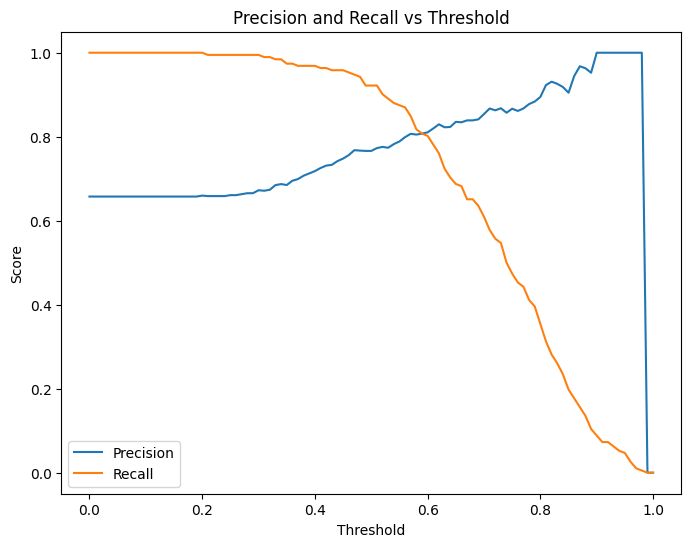

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()




In [14]:
diff = np.abs(np.array(precisions) - np.array(recalls))
intersection_idx = np.argmin(diff)
intersection_threshold = thresholds[intersection_idx]

print("Intersection threshold:", round(intersection_threshold, 3))

Intersection threshold: 0.59


Q4

In [15]:
max(f1score,key=f1score.get)

np.float64(0.47000000000000003)

Q5

In [18]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd

df_kfold = df.copy()
y = df_kfold['converted'].values
X = df_kfold.drop(columns=['converted'])

# Define preprocessing steps
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(exclude='object').columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

kf = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Create and train logistic regression pipeline with preprocessing
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(solver='liblinear', C=1.0, max_iter=1000))
    ])
    model.fit(X_train, y_train)

    # Predict probabilities and compute AUC
    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    auc_scores.append(auc)

In [19]:
std_auc = np.std(auc_scores)
print("Standard deviation of AUCs:", round(std_auc, 3))


Standard deviation of AUCs: 0.029


Q6

In [21]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)


for c in [0.000001, 0.001, 1]:
  auc_scores_c = []
  mean={}
  for train_idx, val_idx in kf.split(X):
      X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
      y_train, y_val = y[train_idx], y[val_idx]

      # Create and train logistic regression pipeline with preprocessing
      model = Pipeline(steps=[
          ('preprocessor', preprocessor),
          ('model', LogisticRegression(solver='liblinear', C=c, max_iter=1000))
      ])
      model.fit(X_train, y_train)

      # Predict probabilities and compute AUC
      y_pred = model.predict_proba(X_val)[:, 1]
      auc = roc_auc_score(y_val, y_pred)
      auc_scores_c.append(auc)
  print(f'The mean for {c} parameter is: {np.mean(auc_scores_c)}')
  mean[c]=np.mean(auc_scores_c)
print(f'The best parameter is: {max(mean,key=mean.get)} with mean score: {max(mean.values())}')

The mean for 1e-06 parameter is: 0.5490018083818466
The mean for 0.001 parameter is: 0.8624023620247024
The mean for 1 parameter is: 0.8208745760125474
The best parameter is: 1 with mean score: 0.8208745760125474
